In [32]:
import os
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def load_tensorboard_tag_matrix(parent_dir, tag=None):
    """
    Load a specific scalar tag from all TensorBoard runs under parent_dir.

    Each subdirectory containing TensorBoard event files is treated as a run.
    Returns a wide-format DataFrame with:
        - one 'step' column
        - one column per run (subdirectory) with the scalar values.

    Parameters
    ----------
    parent_dir : str
        Parent directory containing subdirectories with TensorBoard event files.
    tag : str or None
        Name of the scalar tag to load. If None, prints available tags from the
        first run found and returns None.

    Returns
    -------
    df : pandas.DataFrame or None
        DataFrame with columns: 'step', <run_1>, <run_2>, ...
        Or None if no data found / tag not specified.
    """
    first_run_tags_printed = False

    all_steps = []
    all_values = []
    all_runs = []

    # Walk through all directories and find those with event files
    for root, dirs, files in os.walk(parent_dir):
        event_files = [f for f in files if f.startswith("events.out.tfevents.")]
        if not event_files:
            continue

        run_name = os.path.relpath(root, parent_dir)

        # Use the directory as the logdir for EventAccumulator so it can merge multiple event files
        ea = EventAccumulator(root)
        try:
            ea.Reload()
        except Exception as e:
            print(f"Could not load events from {root}: {e}")
            continue

        scalar_tags = ea.Tags().get("scalars", [])

        # If tag is not specified, print tags from the first run and bail
        if tag is None:
            if not first_run_tags_printed:
                print(f"Available scalar tags in run '{run_name}':")
                for t in scalar_tags:
                    print("  •", t)
                first_run_tags_printed = True
            # We don't construct the matrix if tag is None
            continue

        if tag not in scalar_tags:
            print(f"Tag '{tag}' not found in run '{run_name}'. Available tags: {scalar_tags}")
            continue

        events = ea.Scalars(tag)
        if not events:
            print(f"No events for tag '{tag}' in run '{run_name}'.")
            continue

        steps = [e.step for e in events]
        values = [e.value for e in events]
        runs = [run_name] * len(steps)

        all_steps.extend(steps)
        all_values.extend(values)
        all_runs.extend(runs)

        print(f"Loaded {len(steps)} items from {run_name}")

    if tag is None:
        print("No tag specified. Call the function again with a tag, e.g. tag='train/loss'.")
        return None
    
    run_df = pd.DataFrame({
        "step": all_steps,
        "value": all_values,
        "run": all_runs
    })
    run_df = run_df.sort_values("step").reset_index(drop=True)
    
    return run_df


In [52]:
logdir = "./runs/"
tag = "collisions"

df = load_tensorboard_tag_matrix(logdir, tag)

Tag 'collisions' not found in run 'Dec03_11-24-44_declan_laptop'. Available tags: []
Tag 'collisions' not found in run 'Dec03_11-25-54_declan_laptop'. Available tags: ['eval_mean_episode_reward', 'eval_mean_episode_old_reward', 'eval_mean_episode_length', 'eval_mean_action_magnitude', 'eval_mean_wheel_velocity']
Loaded 10000 items from pygame_manualsafetylayer
Loaded 8399 items from pygame_nosafetylayer
Loaded 10000 items from pygame_nosafetylayer_600e
Loaded 10000 items from pygame_nosafetylayer_600to1200e
Loaded 7660 items from pygame_rewardshaping_01
Loaded 7891 items from pygame_rewardshaping_1_0to300e
Loaded 7128 items from pygame_rewardshaping_1_300to600e
Loaded 10000 items from pygame_rewardshaping_600e
Loaded 6655 items from pygame_safetylayer
Loaded 10000 items from pygame_safetylayer_60e_600e


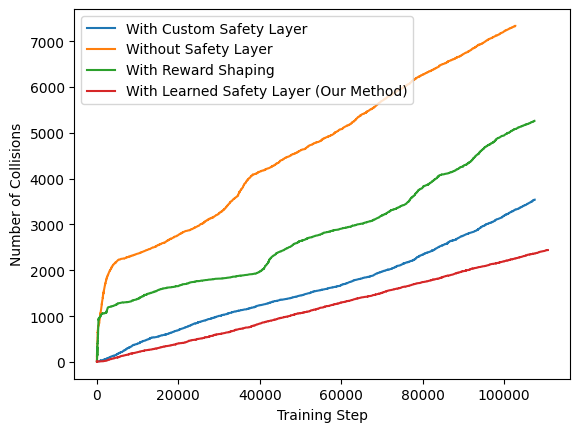

In [55]:
import matplotlib.pyplot as plt

to_plot = {
    "pygame_nosafetylayer_600e": "Without Safety Layer",
    "pygame_safetylayer_60e_600e": "With Learned Safety Layer (Our Method)",
    "pygame_rewardshaping_600e": "With Reward Shaping",
    "pygame_manualsafetylayer": "With Custom Safety Layer"
}

for run, run_df in df.groupby("run"):
    if run in to_plot:
        label = to_plot[run]
        sorted = run_df.sort_values("step")
        #values = sorted["value"].rolling(200).mean()
        values = sorted["value"]
        plt.plot(sorted["step"], values, label=label)

plt.legend()
plt.xlabel("Training Step")
plt.ylabel("Number of Collisions")
#plt.show()
plt.savefig('pygame_env_collisions.png', bbox_inches='tight')